# Basic Filtering in Python
### Implementing basic high, low, bandpass, bandstop filters in Python
#### Ryan Marren, Sept 26 2016

This is some filtering done in python to both demonstrate understanding after Greg's lab session, and to have a reference for when we must do this type of filtering on the EEG data (e.g., in the pre-processing).

Lets start with some sine-waves

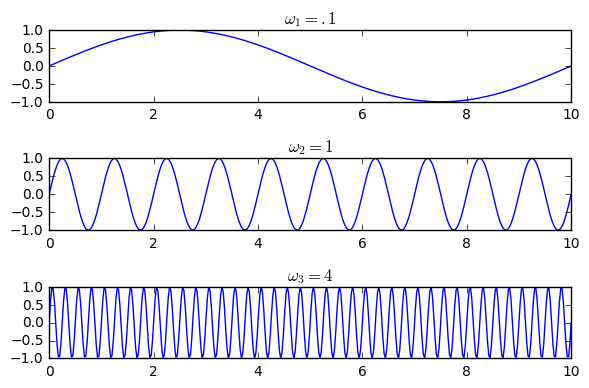

In [1]:
import numpy as np
import matplotlib.pyplot as plt
T = 10 # We consider a signal lasting 1000 seconds
Fs = 40 # We sample the signal at 40 Hz (2 * w3, so the nyquist frequency)
w1 = .1
w2 = 1
w3 = 4
sample_points = np.linspace(0, T, T * Fs)
sines_w1 = np.sin(w1 * 2 * np.pi * sample_points)
sines_w2 = np.sin(w2 * 2 * np.pi * sample_points)
sines_w3 = np.sin(w3 * 2 * np.pi * sample_points)
plt.subplot(3, 1, 1)
plt.plot(sample_points, sines_w1)
plt.title(r'$\omega_1 = .1$')
plt.subplot(3, 1, 2)
plt.plot(sample_points, sines_w2)
plt.title(r'$\omega_2 = 1$')
plt.subplot(3, 1, 3)
plt.plot(sample_points, sines_w3)
plt.title(r'$\omega_3 = 4$')
plt.tight_layout()
plt.show()

Summing these signals gives:

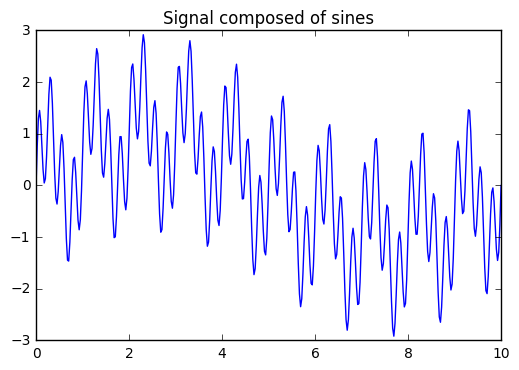

In [2]:
signal = sines_w1 + sines_w2 + sines_w3
plt.plot(sample_points, signal)
plt.title('Signal composed of sines')
plt.show()

We can convert this signal to the frequency domain with a Fourier Transform to see what frequency signals compose it:

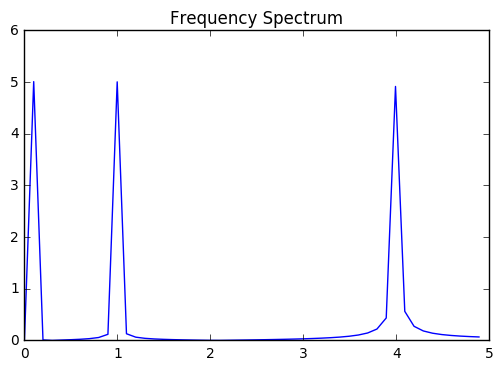

In [3]:
# abs to get the real part, and we take the second half of the data to remove the symmetry
dt = sample_points[1] - sample_points[0]
ft = np.fft.fft(signal) * dt
ft = ft[: len(sample_points)/2]
freq = np.fft.fftfreq(len(sample_points), dt)
freq = freq[:len(sample_points)/2]
plt.plot(freq[0:50] , np.abs(ft)[0:50])
plt.title('Frequency Spectrum')
plt.show()

As we can see, there are spikes at $\omega_1 = 0.1, \omega_2 = 1$, $\omega_3 = 4$

Now let's see what kind of filtering we can do to extract different frequency components of the signal. First, lets try a low-pass filter to get rid of the $\omega_3$ component.

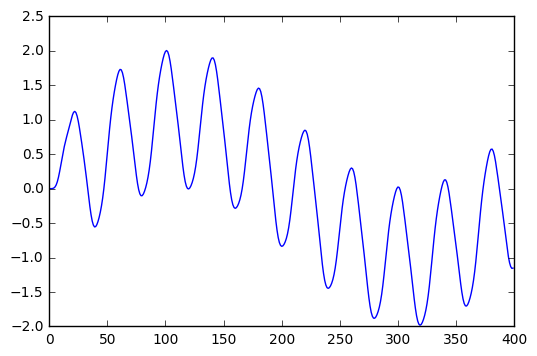

In [4]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, Fs, order=5):
    nyq = 0.5 * Fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, Fs, order=5):
    b, a = butter_lowpass(cutoff, Fs, order=order)
    y = lfilter(b, a, data)
    return y

signal_lp = butter_lowpass_filter(signal, 2, Fs, 5)
plt.plot(signal_lp)
plt.show()

The preceding filtering process was a low-pass filter, meaning that frequencies lower than a certain cutoff make it through the filter and frequencies above a certain cutoff are attenuated.

We used $\omega = 2$ as the cutoff, so the frequency components $\omega_1 = 0.1$ and $\omega_2 = 1$ made it through while the $\omega_3 = 4$ component went away, which results in a smoother graph than the original.

We can see the results also if we go back to the frequency domain by noticing the spike at $\omega_3 = 4$ going away.

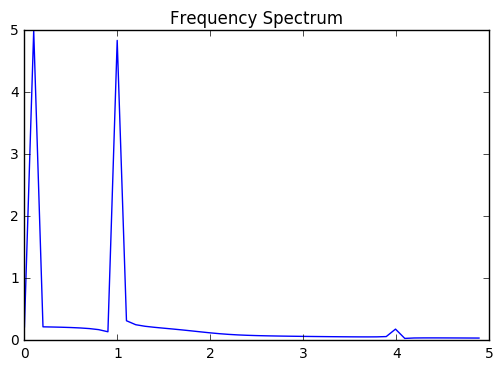

In [5]:
ft_lp = np.fft.fft(signal_lp) * dt
ft_lp = ft_lp[: len(sample_points)/2]
plt.plot(freq[0:50] , np.abs(ft_lp)[0:50])
plt.title('Frequency Spectrum')
plt.show()

Now let's try to use a high-pass filter to get rid of the low frequency $\omega_1$.

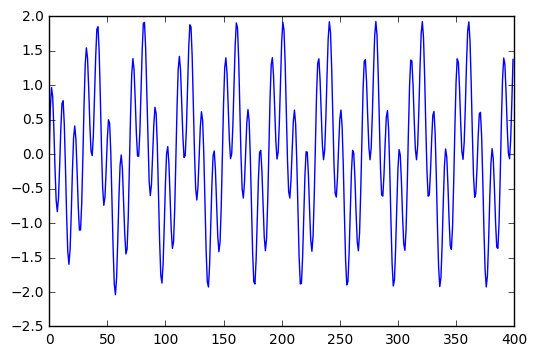

In [6]:
from scipy.signal import butter, lfilter, freqz

def butter_highpass(cutoff, Fs, order=5):
    nyq = 0.5 * Fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, Fs, order=5):
    b, a = butter_highpass(cutoff, Fs, order=order)
    y = lfilter(b, a, data)
    return y

signal_hp = butter_highpass_filter(signal, .5, Fs, 5)
plt.plot(signal_hp)
plt.show()

As we can see, the slow up and down movement of the general spiky pattern was removed, which resembles the low frequency component of the signal being attenuated.

We can also see this result in the frequency domain, as resembled by the spike at $\omega_1 = 0.1$ going away:

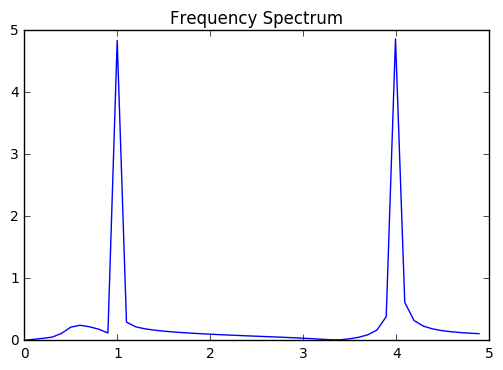

In [7]:
ft_hp = np.fft.fft(signal_hp) * dt
ft_hp = ft_hp[: len(sample_points)/2]
plt.plot(freq[0:50] , np.abs(ft_hp)[0:50])
plt.title('Frequency Spectrum')
plt.show()

Finally, we can use a bandpass filter which can isolate the middle frequency component $\omega_2 = 1$. We implement as follows:

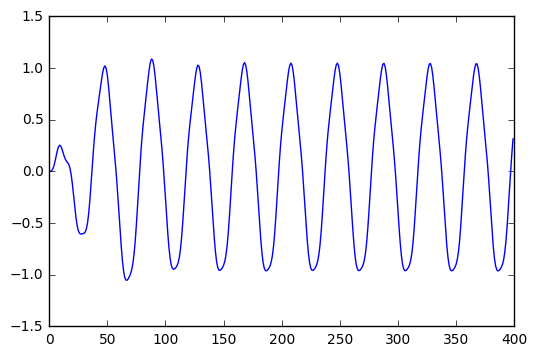

In [8]:
from scipy.signal import butter, lfilter, freqz

def butter_bandpass(cutoff, Fs, order=5):
    nyq = 0.5 * Fs
    lowcut = cutoff[0] / nyq
    highcut = cutoff[1] / nyq
    b, a = butter(order, [lowcut, highcut], btype='bandpass', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, Fs, order=5):
    b, a = butter_bandpass(cutoff, Fs, order=order)
    y = lfilter(b, a, data)
    return y

signal_bp = butter_bandpass_filter(signal, [.6, 2], Fs, 3)
plt.plot(signal_bp)
plt.show()

and we can see that the middle frequency component is all thats left! We can prove it in the frequency domain:

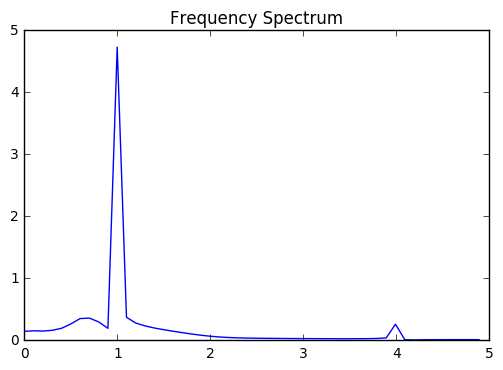

In [9]:
ft_bp = np.fft.fft(signal_bp) * dt
ft_hb = ft_bp[: len(sample_points)/2]
plt.plot(freq[0:50] , np.abs(ft_bp)[0:50])
plt.title('Frequency Spectrum')
plt.show()

This is useful, but for our EEG data we want the inverse of this process. Namely, there is a lot of noise at 60 Hz because of the power line component. What we want is a 'notch' filter, which keeps everything except for the frequency within a certain range. This can be implemented as follows:

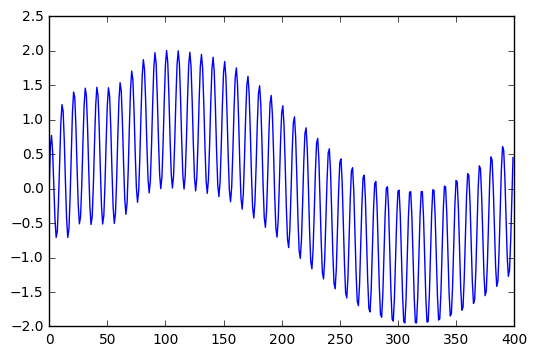

In [10]:
from scipy.signal import butter, lfilter, freqz

def butter_bandstop(cutoff, Fs, order=5):
    nyq = 0.5 * Fs
    lowcut = cutoff[0] / nyq
    highcut = cutoff[1] / nyq
    b, a = butter(order, [lowcut, highcut], btype='bandstop', analog=False)
    return b, a

def butter_bandstop_filter(data, cutoff, Fs, order=5):
    b, a = butter_bandstop(cutoff, Fs, order=order)
    y = lfilter(b, a, data)
    return y

signal_bs = butter_bandstop_filter(signal, [.6, 2], Fs, 3)
plt.plot(signal_bs)
plt.show()

And we see a composition of low and high frequency components (e.g., the $\omega_2$ component is gone!). We can show this in the frequency domain to conclude this exercise:

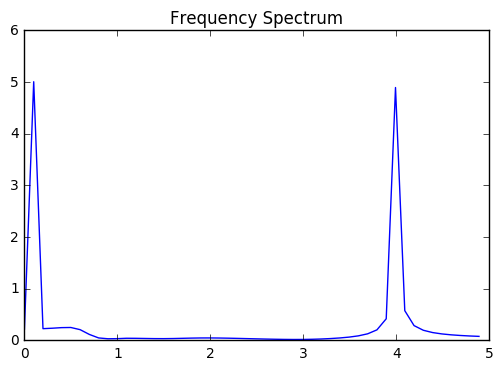

In [11]:
ft_bs = np.fft.fft(signal_bs) * dt
ft_bs = ft_bs[: len(sample_points)/2]
plt.plot(freq[0:50] , np.abs(ft_bs)[0:50])
plt.title('Frequency Spectrum')
plt.show()